# DBpedia Schema Queries

## Overview

In this notebook,  I begin the process of analyzing the schema of the [DBpedia Ontology](http://mappings.dbpedia.org/index.php/How_to_edit_the_DBpedia_Ontology).
This is a local notebook in which I load data from the filesystem into an in-memory graph,  thus it is
part of the unit tests for gastrodon.  This is feasible because the schema is much smaller than DBpedia as a whole.

The following diagram illustrates the relationships between DBpedia Ontology,  it's parts,  DBpedia,  and the world it describes

<img src="img/what-it-represents.png" width="861" height="311">

The numbers above are really rough (by as much as [30 orders of magnitude](https://physics.stackexchange.com/questions/35920/maximum-possible-information-in-the-universe))),  but some key points are:

* The DBpedia Ontology has it's own Ontology,  which is a subset of RDFS,  OWL,  Dublin Core,  Prov and similar vocabularies
* The DBpedia Ontology is much smaller (thousands of times) than DBpedia itself
* DBpedia does not directly describe the external universe,  but instead describes Wikipedia,  which itself describes the universe.

It's important to keep these layers straight,  because in this notebook,  we are looking at a description of the vocabulary used in DBpedia that uses RDFS, OWL, etc. vocabulary.  RDF is unusual among data representations in that schemas in RDF are themselves written in RDF,  and can be joined together with the data they describe.  In this case,  however,  I've separated out a small amount of schema data that I intend to use to control operations against a larger database,  much like the program of a numerically controlled machine tool or the punched cards that control a [Jacquard Loom](https://en.wikipedia.org/wiki/Jacquard_loom).

This notebook is part of the test suite for the Gastrodon framework,  and a number of bugs were squashed and API improvements made in the process of creating it.  It will be of use to anyone who wants to better understand RDF,  SPARQL,  DBPedia, Pandas,  and how to put it all together with Gastrodon.

## Setup

As always,  I import names from the Python packages I use:

In [1]:
%matplotlib inline

import sys
from rdflib import Graph,URIRef
from gastrodon import LocalEndpoint,one,QName
import gzip
import pandas as pd
pd.set_option("display.width",100)
pd.set_option("display.max_colwidth",80)

## Loading the graph

I [Zopfli](https://en.wikipedia.org/wiki/Zopfli) compressed a copy of the DBpedia Ontology from version 2015-10,  so I can load it like so:

In [2]:
g=Graph()

In [3]:
g.parse(gzip.open("data/dbpedia_2015-10.nt.gz"),format="nt")

<Graph identifier=N1ff69bed952145658b2800fb345c46b7 (<class 'rdflib.graph.Graph'>)>

Now it is loaded in memory in an RDF graph which I can do SPARQL queries on;  think of it as a hashtable on steroids.  I can get the size of the graph (number of triples) the same way I would get the size of any Python object:

In [4]:
len(g)

30318

The Graph is supplied by RDFLib,  but I wrap it in an Endpoint object supplied by Gastrodon;  this provides a bridge between RDFLib and pandas as well as smoothing away the difference between a local endpoint and remote endpoints (a SPARQL database running in another process or on another computer)

In [5]:
e=LocalEndpoint(g)

## Counting properties and discovering namespaces

Probably the best query to run on an unfamiliar database is to count the properties (predicates) used in it.  Note that the predicates that I'm working with in this stage are the predicates that make up the DBpedia Ontology,  they are not the predicates that are used in the larger DBpedia Ontology.  I'll show you those later.

In [6]:
properties=e.select("""
   SELECT ?p (COUNT(*) AS ?cnt) {
      ?s ?p ?o .
   } GROUP BY ?p ORDER BY DESC(?cnt)
""")
properties

,cnt
p,
rdfs:label,11645
rdf:type,6681
http://www.w3.org/ns/prov#wasDerivedFrom,3434
rdfs:range,2558
rdfs:domain,2407
rdfs:comment,1208
rdfs:subPropertyOf,971
rdfs:subClassOf,748
http://www.w3.org/2002/07/owl#equivalentClass,407


Note that the leftmost column is bold;  this is because gastrodon recognized that this query groups on the `?p` variable and it made this an [index](http://pandas.pydata.org/pandas-docs/stable/indexing.html) of the pandas dataframe.  Gastrodon uses the SPARQL parser from RDFLib to understand your queries to support you in writing and displaying them.  One advantage of this is that if you want to make a plot from the above data frame (which I'll do in a moment after cleaning the data) the dependent and independent variables will be automatically determined and things will 'just work'.

Another thing to note is that the table shows short names such as `rdfs:label` as well as full URIs for predicates.  The full URIs are tedious to work with,  so I add a number of namespace declarations
and make a new `LocalEndpoint`

In [7]:
g.bind("prov","http://www.w3.org/ns/prov#")
g.bind("owl","http://www.w3.org/2002/07/owl#")
g.bind("cc","http://creativecommons.org/ns#")
g.bind("foaf","http://xmlns.com/foaf/0.1/")
g.bind("dc","http://purl.org/dc/terms/")
g.bind("vann","http://purl.org/vocab/vann/")

In [8]:
e=LocalEndpoint(g)
properties=e.select("""
   SELECT ?p (COUNT(*) AS ?cnt) {
      ?s ?p ?o .
   } GROUP BY ?p ORDER BY DESC(?cnt)
""")
properties

,cnt
p,
rdfs:label,11645
rdf:type,6681
prov:wasDerivedFrom,3434
rdfs:range,2558
rdfs:domain,2407
rdfs:comment,1208
rdfs:subPropertyOf,971
rdfs:subClassOf,748
owl:equivalentClass,407


## Metadata about the DBpedia Ontology

I find it suspicious that so many properties occur only once,  so I investigate:

In [9]:
single=e.select("""
   SELECT ?s {
      ?s dc:source ?o .
    }
""")
single

,s
0,http://dbpedia.org/ontology/


The `one` function will extract the single member of any list, iterable, DataFrame, or Series that has just one member.

In [10]:
ontology=one(single)

The `select` function can see variables in the stack frame that calls it.  Simply put,  if you use the `?_ontology` variable in a SPARQL query,  `select` will look for a Python variable called `ontology`,  and substitute the value of `ontology` into `?_ontology`.  The underscore sigil prevents substitutions from happening by accident.

and we see here a number of facts about the DBpedia Ontology,  that is,  the data set we are working with.

In [11]:
meta=e.select("""
    SELECT ?p ?o {
        ?_ontology ?p ?o .
    } ORDER BY ?p
""")
meta

,p,o
0,cc:license,http://creativecommons.org/licenses/by-sa/3.0/
1,cc:license,http://www.gnu.org/copyleft/fdl.html
2,dc:creator,DBpedia Maintainers and Contributors
3,dc:description,\n The DBpedia ontology provides the classes and properties use...
4,dc:issued,2008-11-17T12:00Z
5,dc:modified,2015-11-02T09:36Z
6,dc:publisher,DBpedia Maintainers
7,dc:source,http://mappings.dbpedia.org
8,dc:title,The DBpedia Ontology
9,vann:preferredNamespacePrefix,dbo


In [12]:
ontology

rdflib.term.URIRef('http://dbpedia.org/ontology/')

## How Gastrodon handles URI References

Gastrodon tries to display things in a simple way while watching your back to prevent mistakes.  One potential mistake is that RDF makes a distinction between a literal string such as `"http://dbpedia.org/ontology/"` and a URI references such as `<http://dbpedia.org/ontology/>`.  Use the wrong one and your queries won't work!

This particularly could be a problem with abbreviated names,  for instance,  let's look at the first predicate in the `meta` frame.  When displayed in as a result of Jupyter notebook or in a Pandas Dataframe,  the short name looks just like a string:

In [13]:
license=meta.at[0,'p']
license

'cc:license'

that's because it is a string!  It's more than a string,  however,  it is a class which is a subclass of string:

In [14]:
type(license)

gastrodon.GastrodonURI

and in fact has the full URI reference hidden away inside of it

In [15]:
meta.at[0,'p'].to_uri_ref()

rdflib.term.URIRef('http://creativecommons.org/ns#license')

When you access this value in a SPARQL query,  the `select` function recognizes the type of the variable and automatically inserts the full URI reference

In [16]:
e.select("""
    SELECT ?s ?o {
        ?s ?_license ?o .
    }
""")

,s,o
0,http://dbpedia.org/ontology/,http://creativecommons.org/licenses/by-sa/3.0/
1,http://dbpedia.org/ontology/,http://www.gnu.org/copyleft/fdl.html


## Counting properties that are not about the Ontology

Since the metadata properties that describe this dataset really aren't part of it,  it makes sense to remove these from the list so that we don't have so many properties that are used just once

In [17]:
properties=e.select("""
   SELECT ?p (COUNT(*) AS ?cnt) {
      ?s ?p ?o .
      FILTER(?s!=?_ontology)
   } GROUP BY ?p ORDER BY DESC(?cnt)
""")
properties

,cnt
p,
rdfs:label,11645
rdf:type,6679
prov:wasDerivedFrom,3434
rdfs:range,2558
rdfs:domain,2407
rdfs:comment,1207
rdfs:subPropertyOf,971
rdfs:subClassOf,748
owl:equivalentClass,407


At this point it is about as easy to make a pie chart as it is with Excel.  A pie chart is a good choice here because each fact has exactly one property in it:

Text(0,0.5,'')

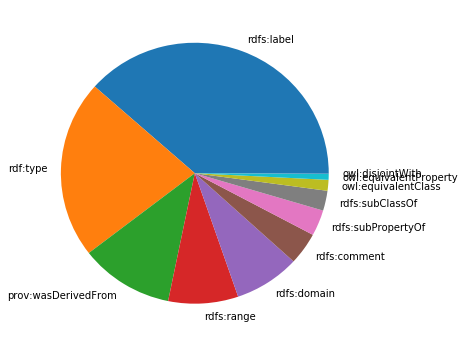

In [18]:
properties["cnt"].plot.pie(figsize=(6,6)).set_ylabel('')

My favorite method for understanding this kind of distribution is to sort the most common properties first and then compute the [Cumulative Distribution Function](https://en.wikipedia.org/wiki/Cumulative_distribution_function),  which is the percentage of facts that have used the predicates we've seen so far.

This is easy to compute with Pandas

In [19]:
100.0*properties["cnt"].cumsum()/properties["cnt"].sum()

p
rdfs:label                 38.429807
rdf:type                   60.471256
prov:wasDerivedFrom        71.803841
rdfs:range                 80.245528
rdfs:domain                88.188898
rdfs:comment               92.172134
rdfs:subPropertyOf         95.376543
rdfs:subClassOf            97.845027
owl:equivalentClass        99.188172
owl:equivalentProperty     99.920797
owl:disjointWith          100.000000
Name: cnt, dtype: float64

Note that this result looks different than the DataFrames you've seen so far because it is not a DataFrame,  it is a series,  which has just one index column and one data column.  It's possible to stick several series together to make a DataFrame,  however.

In [20]:
pd.DataFrame.from_items([
    ('count',properties["cnt"]),
    ("frequency",100.0*properties["cnt"]/properties["cnt"].sum()),
    ("distribution",100.0*properties["cnt"].cumsum()/properties["cnt"].sum())
])

,count,frequency,distribution
p,,,
rdfs:label,11645,38.429807,38.429807
rdf:type,6679,22.041449,60.471256
prov:wasDerivedFrom,3434,11.332585,71.803841
rdfs:range,2558,8.441687,80.245528
rdfs:domain,2407,7.943370,88.188898
rdfs:comment,1207,3.983235,92.172134
rdfs:subPropertyOf,971,3.204409,95.376543
rdfs:subClassOf,748,2.468484,97.845027
owl:equivalentClass,407,1.343146,99.188172


Unlike many graphical depictions,  the above chart is fair to both highly common and unusually rare predicates.

## Languages

It makes sense to start with `rdf:label`,  which is the most common property in this database.

Unlike many data formats,  RDF supports language tagging for strings.  Objects (mainly properties and classes used in DBpedia) that are talked about in the DBpedia Ontology are described in multiple human languages,  and counting the language tags involves a query that is very similar to the property counting query:

In [21]:
e.select("""
   SELECT (LANG(?label) AS ?lang) (COUNT(*) AS ?cnt) {
      ?s rdfs:label ?label .
   } GROUP BY LANG(?label) ORDER BY DESC(?cnt)
""")

,lang,cnt
0,en,3953
1,de,2049
2,nl,1296
3,el,1227
4,fr,755
5,ga,469
6,ja,374
7,sr,259
8,es,256
9,it,244


A detail you might notice is that the lang column is not bolded,  instead,  a sequential numeric index was created when I made the data frame.  This is because Gastrodon,  at this moment,  isn't smart enough to understand a function that appears in the `GROUP BY` clause.

This is easy to work around by assinging the output of this function to a variable in a `BIND` clause.

In [22]:
lang=e.select("""
   SELECT ?lang (COUNT(*) AS ?cnt) {
      ?s rdfs:label ?label .
      BIND (LANG(?label) AS ?lang)
   } GROUP BY ?lang ORDER BY DESC(?cnt)
""")
lang

,cnt
lang,
en,3953
de,2049
nl,1296
el,1227
fr,755
ga,469
ja,374
sr,259
es,256


One key to getting correct results in a data analysis is to test your assumptions.  English is the most prevalent language by far,  but can we assume that every object has an English name?  There are 3593 objects with English labels,  but

In [23]:
distinct_s=one(e.select("""
   SELECT (COUNT(DISTINCT ?s) AS ?cnt) {
      ?s rdfs:label ?o .
   }
"""))
distinct_s

3954

objects with labels overall,  so there must be at least one object without an English label.  SPARQL has negation operators so we can find objects like that:

In [24]:
black_sheep=one(e.select("""
   SELECT ?s {
      ?s rdfs:label ?o .
      FILTER NOT EXISTS {
          ?s rdfs:label ?o2 .
          FILTER(LANG(?o2)='en')
      }
   }
"""))
black_sheep

rdflib.term.URIRef('http://dbpedia.org/ontology/hasSurfaceForm')

Looking up all the facts for that object (which is a property used in DBpedia) shows that it has a name in greek,  but not any other language

In [25]:
meta=e.select("""
    SELECT ?p ?o {
        ?_black_sheep ?p ?o .
    } ORDER BY ?p
""")
meta

,p,o
0,rdf:type,rdf:Property
1,rdf:type,owl:DatatypeProperty
2,rdfs:comment,Reserved for DBpedia.
3,rdfs:label,επιφάνεια από
4,rdfs:range,xsd:string
5,prov:wasDerivedFrom,http://mappings.dbpedia.org/index.php/OntologyProperty:hasSurfaceForm


I guess that's the exception that proves the rule.  Everything else has a name in English,  about half of the schema objects have a name in German,  and the percentage falls off pretty rapidly from there:

In [26]:
lang_coverage=100*lang["cnt"]/distinct_s
lang_coverage

lang
en    99.974709
de    51.820941
nl    32.776935
el    31.031866
fr    19.094588
ga    11.861406
ja     9.458776
sr     6.550329
es     6.474456
it     6.170966
ko     5.993930
pt     5.589277
pl     3.034901
gl     0.986343
tr     0.682853
sl     0.657562
ca     0.657562
ru     0.480526
bg     0.278199
zh     0.278199
id     0.151745
ar     0.126454
bn     0.101163
be     0.101163
eu     0.101163
hy     0.025291
lv     0.025291
cs     0.025291
Name: cnt, dtype: float64

As the percentages add up to more than 100 (an object can have names in many languages),  the pie chart would be a wrong choice,  but a bar chart is effective.

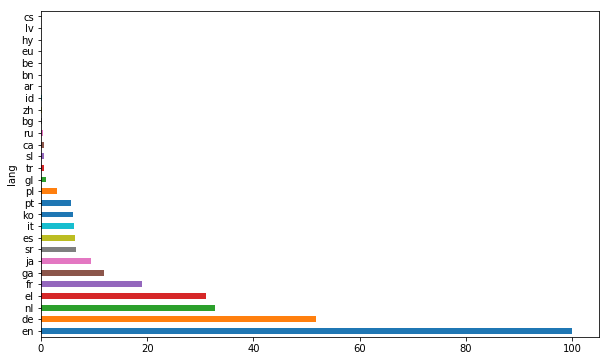

In [27]:
lang_coverage.plot(kind="barh",figsize=(10,6))

## Classes used in the DBpedia Ontology

I use another `GROUP BY` query to count classes used in the DBpedia Ontology.  In the name of keeping the levels of abstraction straight,  I'll point out that there are eight classes in the DBpedia Ontology,  but that the DBpedia Ontology describes 739 classes used in DBpedia.

In [28]:
types=e.select("""
   SELECT ?type (COUNT(*) AS ?cnt) {
      ?s a ?type .
   } GROUP BY ?type ORDER BY DESC(?cnt)
""")
types

,cnt
type,
rdf:Property,2695
owl:DatatypeProperty,1734
owl:ObjectProperty,1099
owl:Class,739
rdfs:Datatype,382
owl:FunctionalProperty,30
owl:Ontology,1
http://purl.org/vocommons/voaf#Vocabulary,1


739 classes are really a lot of classes!  You personally might be interested in some particular domain (say Pop Music) but to survey the whole thing,  I need some way to pick out classes which are important.

If I had access to the whole DBpedia database,  I could count how many instances of these classes occur,  and that would be one measure of importance.  (I have access to this database,  as do you,  but I'm not using it for this notebook because I want this notebook to be self-contained)

As it is,  one proxy for importance is how many properties apply to a particular class,  or,  in RDFS speak,  how many properties have this class as the domain.  The assumption here is that important classes are well documented,  and we get a satisfying list of the top 20 classes this way

In [29]:
types=e.select("""
   SELECT ?s (COUNT(*) AS ?cnt) {
      ?s a owl:Class .
      ?p rdfs:domain ?s .
   } GROUP BY ?s ORDER BY DESC(?cnt) LIMIT 20
""")
types

,cnt
s,
http://dbpedia.org/ontology/Person,253
http://dbpedia.org/ontology/Place,183
http://dbpedia.org/ontology/PopulatedPlace,151
http://dbpedia.org/ontology/Athlete,94
http://dbpedia.org/ontology/Settlement,56
http://dbpedia.org/ontology/School,47
http://dbpedia.org/ontology/SpaceMission,43
http://dbpedia.org/ontology/Island,38
http://dbpedia.org/ontology/MilitaryUnit,29


Adding another namespace binding makes sense to make the output more managable

In [30]:
g.bind("dbo","http://dbpedia.org/ontology/")
e=LocalEndpoint(g)
types=e.select("""
   SELECT ?s (COUNT(*) AS ?cnt) {
      ?s a owl:Class .
      ?p rdfs:domain ?s .
   } GROUP BY ?s ORDER BY DESC(?cnt) LIMIT 5
""")
types.head()

,cnt
s,
dbo:Person,253
dbo:Place,183
dbo:PopulatedPlace,151
dbo:Athlete,94
dbo:Settlement,56


## Common properties for People

To survey some important properties that apply to a `dbo:Person` I need some estimate of importance.  I choose to count how many languages a property is labeled with as a proxy for importance -- after all,  if a property is broadly interesting,  it will be translated into many languages.  The result is pretty satisfying.

In [31]:
person_types=e.select("""
   SELECT ?p (COUNT(*) AS ?cnt) {
       ?p rdfs:domain dbo:Person .
       ?p rdfs:label ?l .
   } GROUP BY ?p ORDER BY DESC(?cnt) LIMIT 30
""")
person_types

,cnt
p,
dbo:birthDate,10
dbo:birthPlace,9
http://dbpedia.org/ontology/Person/weight,8
http://dbpedia.org/ontology/Person/height,8
dbo:nationality,7
dbo:knownFor,7
dbo:eyeColor,6
dbo:residence,6
dbo:child,6


To make something that looks like a real report,  I reach into my bag of tricks.

Since the predicate URI contains an English name for the predicate,  I decide to show a label in German.  The `OPTIONAL` clause is essential so that we don't lose properties that don't have a German label (there is exactly one in the list below).  I use
a subquery to compute the language count,  and then filter for properties that have more than one language.

In [32]:
e.select("""
   SELECT ?p ?range ?label ?cnt {
        ?p rdfs:range ?range .
        OPTIONAL { 
            ?p rdfs:label ?label .
             FILTER(LANG(?label)='de')
        }
        {
           SELECT ?p (COUNT(*) AS ?cnt) {
               ?p rdfs:domain dbo:Person .
               ?p rdfs:label ?l .
           } GROUP BY ?p ORDER BY DESC(?cnt)
        }
       FILTER(?cnt>4)
   } ORDER BY DESC(?cnt)
""")

,p,range,label,cnt
0,dbo:birthDate,xsd:date,Geburtsdatum,10
1,dbo:birthPlace,dbo:Place,Geburtsort,9
2,http://dbpedia.org/ontology/Person/weight,http://dbpedia.org/datatype/kilogram,Gewicht (kg),8
3,http://dbpedia.org/ontology/Person/height,http://dbpedia.org/datatype/centimetre,Höhe (cm),8
4,dbo:nationality,dbo:Country,Nationalität,7
5,dbo:deathPlace,dbo:Place,Sterbeort,6
6,dbo:school,dbo:EducationalInstitution,schule,6
7,dbo:residence,dbo:Place,Residenz,6
8,dbo:eyeColor,xsd:string,Augenfarbe,6
9,dbo:placeOfBurial,dbo:Place,Ort der Bestattung,6


## Towards a simple schema browser

You'd probably agree with me that the query above is getting to be a bit much,  but now that I have it,  I can bake it into a function which makes it easy to ask questions of the schema.  The following query lets us make a similar report for any class and any language.  (I use the German word for 'class' because the English word class and the synonymous word type are both reserved words in Python.)

In [33]:
def top_properties(klasse='dbo:Person',lang='de',threshold=4):
    klasse=QName(klasse)
    df=e.select("""
       SELECT ?p ?range ?label ?cnt {
            ?p rdfs:range ?range .
            OPTIONAL { 
                ?p rdfs:label ?label .
                 FILTER(LANG(?label)=?_lang)
            }
            {
               SELECT ?p (COUNT(*) AS ?cnt) {
                   ?p rdfs:domain ?_klasse .
                   ?p rdfs:label ?l .
               } GROUP BY ?p ORDER BY DESC(?cnt)
            }
           FILTER(?cnt>?_threshold)
       } ORDER BY DESC(?cnt)
    """)
    return df.style.highlight_null(null_color='red')

Note that the `select` here can see variables in the immediately enclosing scope,  that is,  the function definition.  As it is inside a function definition,  it does not see variables defined in the Jupyter notebook.  The [handling of missing values](http://pandas.pydata.org/pandas-docs/stable/missing_data.html#) is a big topic in Pandas,  so I take the liberty of highlighting the label that is missing in German.

In [34]:
top_properties()

,p,range,label,cnt
0,dbo:birthDate,xsd:date,Geburtsdatum,10
1,dbo:birthPlace,dbo:Place,Geburtsort,9
2,http://dbpedia.org/ontology/Person/weight,http://dbpedia.org/datatype/kilogram,Gewicht (kg),8
3,http://dbpedia.org/ontology/Person/height,http://dbpedia.org/datatype/centimetre,Höhe (cm),8
4,dbo:nationality,dbo:Country,Nationalität,7
5,dbo:deathPlace,dbo:Place,Sterbeort,6
6,dbo:school,dbo:EducationalInstitution,schule,6
7,dbo:residence,dbo:Place,Residenz,6
8,dbo:eyeColor,xsd:string,Augenfarbe,6
9,dbo:placeOfBurial,dbo:Place,Ort der Bestattung,6


In Japanese,  a different set of labels is missing.  It's nice to see that Unicode characters outside the `latin-1` codepage work just fine.

In [35]:
top_properties(lang='ja')

,p,range,label,cnt
0,dbo:birthDate,xsd:date,生年月日,10
1,dbo:birthPlace,dbo:Place,生地,9
2,http://dbpedia.org/ontology/Person/weight,http://dbpedia.org/datatype/kilogram,体重 (kg),8
3,http://dbpedia.org/ontology/Person/height,http://dbpedia.org/datatype/centimetre,身長 (cm),8
4,dbo:nationality,dbo:Country,国籍,7
5,dbo:deathPlace,dbo:Place,死没地,6
6,dbo:school,dbo:EducationalInstitution,None,6
7,dbo:residence,dbo:Place,居住地,6
8,dbo:eyeColor,xsd:string,None,6
9,dbo:placeOfBurial,dbo:Place,None,6


And of course it can be fun to look at other classes and languages:

In [36]:
top_properties('dbo:SpaceMission',lang='fr',threshold=1)

,p,range,label,cnt
0,dbo:spacecraft,dbo:Spacecraft,véhicule spatial,4
1,http://dbpedia.org/ontology/SpaceMission/distanceTraveled,http://dbpedia.org/datatype/kilometre,None,3
2,http://dbpedia.org/ontology/SpaceMission/mass,http://dbpedia.org/datatype/kilogram,None,3
3,dbo:distanceTraveled,xsd:double,None,3
4,dbo:nextMission,dbo:SpaceMission,mision siguiente,3
5,dbo:landingSite,xsd:string,None,2
6,dbo:launchPad,dbo:LaunchPad,None,2
7,dbo:landingDate,xsd:date,None,2
8,http://dbpedia.org/ontology/SpaceMission/missionDuration,http://dbpedia.org/datatype/day,None,2
9,dbo:numberOfOrbits,xsd:nonNegativeInteger,None,2


## About "prov:wasDerivedFrom"

The `prov:wasDerivedFrom` property links properties and classes defined in the DBpedia Ontology to the places where they are defined on the mappings web site.

In [37]:
e.select("""
    SELECT ?s ?o {
       ?s prov:wasDerivedFrom ?o .
    } LIMIT 10
""")

,s,o
0,dbo:dateOfAbandonment,http://mappings.dbpedia.org/index.php/OntologyProperty:dateOfAbandonment
1,dbo:Moss,http://mappings.dbpedia.org/index.php/OntologyClass:Moss
2,dbo:CountrySeat,http://mappings.dbpedia.org/index.php/OntologyClass:CountrySeat
3,dbo:Archeologist,http://mappings.dbpedia.org/index.php/OntologyClass:Archeologist
4,dbo:numberOfOfficials,http://mappings.dbpedia.org/index.php/OntologyProperty:numberOfOfficials
5,dbo:nflCode,http://mappings.dbpedia.org/index.php/OntologyProperty:nflCode
6,dbo:parkingLotsCars,http://mappings.dbpedia.org/index.php/OntologyProperty:parkingLotsCars
7,dbo:personName,http://mappings.dbpedia.org/index.php/OntologyProperty:personName
8,dbo:Jockey,http://mappings.dbpedia.org/index.php/OntologyClass:Jockey
9,dbo:licensee,http://mappings.dbpedia.org/index.php/OntologyProperty:licensee


In [38]:
_.at[0,'o']

rdflib.term.URIRef('http://mappings.dbpedia.org/index.php/OntologyProperty:dateOfAbandonment')

## Subclasses

Subclasses can be queried with queries like the following,  which lists direct subtypes of `dbo:Person`.

In [39]:
e.select("""
   SELECT ?type {
      ?type rdfs:subClassOf dbo:Person .
   }
""")

,type
0,dbo:MovieDirector
1,dbo:Religious
2,dbo:Cleric
3,dbo:Scientist
4,dbo:Psychologist
5,dbo:Linguist
6,dbo:Artist
7,dbo:Criminal
8,dbo:TelevisionDirector
9,dbo:Philosopher


SPARQL 1.1 has property path operators that will make the query engine recurse through multiple `rdfs:subClassOf` property links.

In [40]:
e.select("""
   SELECT ?type {
      ?type rdfs:subClassOf* dbo:Person .
   }
""")

,type
0,dbo:Person
1,dbo:MovieDirector
2,dbo:Religious
3,dbo:Cleric
4,dbo:Priest
5,dbo:Cardinal
6,dbo:Vicar
7,dbo:ChristianPatriarch
8,dbo:Pope
9,dbo:Saint


The previous queries work "down" from a higher-level class,  but by putting a '^' before the property name,  I can reverse the direction of traversal,  to find all topics which `dbo:Painter` is a subclass of.

In [41]:
e.select("""
   SELECT ?type {
      ?type ^rdfs:subClassOf* dbo:Painter .
   }
""")

,type
0,dbo:Painter
1,dbo:Artist
2,dbo:Person
3,dbo:Agent
4,owl:Thing


In [42]:
e.select("""
   SELECT ?type {
      dbo:Painter rdfs:subClassOf* ?type .
   }
""")

,type
0,dbo:Painter
1,dbo:Artist
2,dbo:Person
3,dbo:Agent
4,owl:Thing


The same outcome can be had by switching the subject and object positions in the triple:

In [43]:
e.select("""
   SELECT ?type {
      dbo:City rdfs:subClassOf* ?type .
   }
""")

,type
0,dbo:City
1,dbo:Settlement
2,dbo:PopulatedPlace
3,dbo:Place
4,owl:Thing


## Equivalent Classes

The DBpedia Ontology uses `owl:equivalentClass` to specify equivalency between DBpedia Ontology types and types used in other popular systems such as wikidata and schema.org:

In [44]:
e.select("""
   SELECT ?a ?b {
    ?a owl:equivalentClass ?b .
   } LIMIT 10
""")

,a,b
0,dbo:Road,http://www.wikidata.org/entity/Q34442
1,dbo:Pope,http://www.wikidata.org/entity/Q19546
2,dbo:Ligament,http://www.wikidata.org/entity/Q39888
3,dbo:MilitaryVehicle,http://schema.org/Product
4,dbo:Astronaut,http://www.wikidata.org/entity/Q11631
5,dbo:WaterRide,http://www.wikidata.org/entity/Q2870166
6,dbo:Deity,http://www.wikidata.org/entity/Q178885
7,dbo:Beer,http://www.wikidata.org/entity/Q44
8,dbo:Event,http://schema.org/Event
9,dbo:Treadmill,http://www.wikidata.org/entity/Q683267


Here are all of the equivalencies between the DBpedia Ontology and [schema.org](http://schema.org/docs/schemas.html).

In [45]:
e.select("""
   SELECT ?a ?b {
    ?a owl:equivalentClass ?b .
    FILTER(STRSTARTS(STR(?b),"http://schema.org/"))
   }
""")

,a,b
0,dbo:MilitaryVehicle,http://schema.org/Product
1,dbo:Event,http://schema.org/Event
2,dbo:Automobile,http://schema.org/Product
3,dbo:Canal,http://schema.org/Canal
4,dbo:Airport,http://schema.org/Airport
5,dbo:Painting,http://schema.org/Painting
6,dbo:SportsTeam,http://schema.org/SportsTeam
7,dbo:City,http://schema.org/City
8,dbo:Sea,http://schema.org/SeaBodyOfWater
9,dbo:SkiArea,http://schema.org/SkiResort


Many of these are as you would expect,  but there are some that are not correct,  given the definition of `owl:equivalentClass` from the [OWL specification](http://www.w3.org/TR/owl2-syntax/#Equivalent_Classes).

<a id="Equivalent_Classes" name="Equivalent_Classes"></a><h4> <span class="mw-headline">9.1.2  Equivalent Classes </span></h4>
<p>An equivalent classes axiom <span class="name">EquivalentClasses( CE<sub>1</sub> ... CE<sub>n</sub> )</span> states that all of the class expressions <span class="name">CE<sub>i</sub></span>, 1 &le; i &le; n, are semantically equivalent to each other. This axiom allows one to use each <span class="name">CE<sub>i</sub></span> as a synonym for each <span class="name">CE<sub>j</sub></span> &mdash; that is, in any expression in the ontology containing such an axiom, <span class="name">CE<sub>i</sub></span> can be replaced with <span class="name">CE<sub>j</sub></span> without affecting the meaning of the ontology. An axiom <span class="name">EquivalentClasses( CE<sub>1</sub> CE<sub>2</sub> )</span> is equivalent to the following two axioms:
</p>
<div class="indent">
<p><span class="name">SubClassOf( CE<sub>1</sub> CE<sub>2</sub> )</span><br />
<span class="name">SubClassOf( CE<sub>2</sub> CE<sub>1</sub> )</span>
</p>
</div>

Put differently,  anything that is a member of one class is a member of the other class and vice versa.  That's true for `dbo:TelevisionEpisode` and `schema:TVEpisode`,  but not true for many cases involving `schema:Product`

In [46]:
g.bind("schema","http://schema.org/")
e=LocalEndpoint(g)
e.select("""
   SELECT ?a ?b {
    ?a owl:equivalentClass ?b .
    FILTER(?b=<http://schema.org/Product>)
   }
""")

,a,b
0,dbo:MilitaryVehicle,schema:Product
1,dbo:Automobile,schema:Product
2,dbo:Locomotive,schema:Product
3,dbo:Ship,schema:Product
4,dbo:Aircraft,schema:Product


I think you'd agree that an Automobile is a Product,  but that a Product is not necessarily an automobile.  In these cases,

```
dbo:Automobile rdfs:subClassOf schema:Product .
```

is more accurate.

Let's take a look at external classes which aren't part of schema.org or wikidata:

In [47]:
e.select("""
    SELECT ?a ?b {
        ?a owl:equivalentClass ?b .
        FILTER(!STRSTARTS(STR(?b),"http://schema.org/"))
        FILTER(!STRSTARTS(STR(?b),"http://www.wikidata.org/"))    
    }
""")

,a,b
0,dbo:Organisation,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#SocialPerson
1,dbo:TopicalConcept,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Concept
2,dbo:UnitOfWork,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Situation
3,dbo:Food,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#FunctionalSubstance
4,dbo:Unknown,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Entity
5,dbo:Activity,http://www.ontologydesignpatterns.org/ont/d0.owl#Activity
6,dbo:ChemicalSubstance,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#ChemicalObject
7,dbo:PenaltyShootOut,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Event
8,dbo:Annotation,http://purl.org/ontology/bibo/Note
9,dbo:GovernmentType,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Concept


To keep track of them all,  I add a few more namespace declarations.

In [48]:
g.bind("dzero","http://www.ontologydesignpatterns.org/ont/d0.owl#")
g.bind("dul","http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#")
g.bind("bibo","http://purl.org/ontology/bibo/")
g.bind("skos","http://www.w3.org/2004/02/skos/core#")
e=LocalEndpoint(g)

In [49]:
e.select("""
    SELECT ?a ?b {
        ?a owl:equivalentClass ?b .
        FILTER(!STRSTARTS(STR(?b),"http://schema.org/"))
        FILTER(!STRSTARTS(STR(?b),"http://www.wikidata.org/"))    
    }
""")

,a,b
0,dbo:Organisation,dul:SocialPerson
1,dbo:TopicalConcept,dul:Concept
2,dbo:UnitOfWork,dul:Situation
3,dbo:Food,dul:FunctionalSubstance
4,dbo:Unknown,dul:Entity
5,dbo:Activity,dzero:Activity
6,dbo:ChemicalSubstance,dul:ChemicalObject
7,dbo:PenaltyShootOut,dul:Event
8,dbo:Annotation,bibo:Note
9,dbo:GovernmentType,dul:Concept


The mapping from `dbo:Film` to `<http://dbpedia.org/ontology/Wikidata:Q11424>` is almost certainly a typo.

## Disjoint Classes

Another bit of OWL vocabulary used in the DBpedia Ontology is `owl:disjointWith`

In [50]:
e.select("""
    SELECT ?b ?a {
        ?a owl:disjointWith ?b .   
    } ORDER BY ?b
""")

,b,a
0,dbo:Fish,dbo:Mammal
1,dbo:HistoricalPeriod,dbo:PrehistoricalPeriod
2,dbo:Person,dbo:On-SiteTransportation
3,dbo:Person,dbo:GeologicalPeriod
4,dbo:Person,dbo:ProtohistoricalPeriod
5,dbo:Person,dbo:MeanOfTransportation
6,dbo:Person,dbo:HistoricalPeriod
7,dbo:Person,dbo:Mine
8,dbo:Person,dbo:UnitOfWork
9,dbo:Person,dbo:TimePeriod


If two classes are disjoint,  that means that nothing can be an instance of both things.  For instance,  a Fish cannot be a Mammal,  a Person is not a building,  etc.  These sort of facts are helpful for validation,  but one should resist the impulse to make statements of disjointness which aren't strictly true.  (For instance,  it would be unlikely,  but not impossible,  to be the winner of both a Heisman Trophy and a Fields Metal,  so these are not disjoint categories.)

## Datatypes

RDF not only has "types" (classes) that represent named concepts,  but it also has literal datatypes.  These include the standard datatypes from XML such as `xsd:integer` and `xsd:datetime`,  but also derived types that specialize those types.  This makes it possible to tag quantities in terms of physical units,  currency units,  etc.

In [51]:
e.select("""
    SELECT ?type {
        ?type a rdfs:Datatype .
    } LIMIT 10
""")

,type
0,http://dbpedia.org/datatype/laoKip
1,http://dbpedia.org/datatype/mexicanPeso
2,http://dbpedia.org/datatype/erg
3,xsd:gYearMonth
4,http://dbpedia.org/datatype/millibar
5,xsd:gYear
6,http://dbpedia.org/datatype/samoanTala
7,http://dbpedia.org/datatype/squareFoot
8,http://dbpedia.org/datatype/terahertz
9,http://dbpedia.org/datatype/uruguayanPeso


In [52]:
g.bind("type","http://dbpedia.org/datatype/")
e=LocalEndpoint(g)

In [53]:
e.select("""
    SELECT ?type {
        ?type a rdfs:Datatype .
    } LIMIT 10
""")

,type
0,type:laoKip
1,type:mexicanPeso
2,type:erg
3,xsd:gYearMonth
4,type:millibar
5,xsd:gYear
6,type:samoanTala
7,type:squareFoot
8,type:terahertz
9,type:uruguayanPeso


The information about these data types are currently sparse:  this particular type has just a label and a type.

In [54]:
e.select("""
    SELECT ?p ?o {
        type:lightYear ?p ?o .
    }
""")

,p,o
0,rdf:type,rdfs:Datatype
1,rdfs:label,lightYear


These turn out to be the only properties that *any* datatypes have;  pretty clearly,  datatypes are not labeled in the rich set of languages that properties and classes are labeled in.  (Note that vocabulary exists in RDFS and OWL for doing just that,  such as specifying that `type:lightYear` would be represented as a number,  specifying that a particular type of numeric value is in a particular range,  etc.)

In [55]:
e.select("""
    SELECT ?p (COUNT(*) AS ?cnt) {
        ?s a rdfs:Datatype .
        ?s ?p ?o .
    } GROUP BY ?p
""")

,cnt
p,
rdf:type,382
rdfs:label,382


Another approach is to look at how datatypes get used,  that is,  how frequently various datatypes are used as the range of a property.

In [56]:
e.select("""
    SELECT ?type (COUNT(*) AS ?cnt) {
        ?p rdfs:range ?type .
        ?type a rdfs:Datatype .
    } GROUP BY ?type ORDER BY DESC(?cnt)
""")

,cnt
type,
xsd:string,779
xsd:nonNegativeInteger,265
xsd:double,187
xsd:date,146
xsd:gYear,60
xsd:integer,53
rdf:langString,49
type:millimetre,26
type:kilogram,25


In [57]:
len(_)

41

Out of 382 properties,  only 41 actually appear as the range of the properties in the schema.  Here are a few properties that are unused in the schema.




In [58]:
e.select("""
    SELECT ?type {
        ?type a rdfs:Datatype .
        MINUS { ?s ?p ?type }
    } LIMIT 20
""")

,type
0,type:laoKip
1,type:mexicanPeso
2,type:erg
3,type:millibar
4,type:samoanTala
5,type:squareFoot
6,type:terahertz
7,type:uruguayanPeso
8,type:turkmenistaniManat
9,type:Density


According to the [DBpedia Ontology documentation](http://mappings.dbpedia.org/index.php/DBpedia_Datatypes),  there are two kinds of datatype declarations in mappings.  In some cases the unit is explictly specified in the mapping field (ex. a field that contains a length is specified in meters) and in other cases,  a particular datatype is *specific* to the field.

It turns out most of the knowledge in the DBpedia Ontology system is hard coded into a [scala file](https://github.com/dbpedia/extraction-framework/blob/master/core/src/main/scala/org/dbpedia/extraction/ontology/OntologyDatatypes.scala);  this file contains rich information that is not exposed in the RDF form of the Ontology,  such as conversion factors,  the fact that miles per hour is a speed,  etc.

It is quite possible to encode datatypes directly into a fact,  for example,

    :Iron :meltsAt "1811 K"^^type:kelvin .


It is possible that such facts could be found in DBpedia or some other database,  but I'm not going to check for that in this notebook,  because this notebook is only considering facts that are in the ontology file supplied with this notebook. 

## Properties Measured in Kilograms

In [59]:

e.select("""
    SELECT ?p {
        ?p rdfs:range type:kilogram
    }
""")

,p
0,http://dbpedia.org/ontology/Spacecraft/totalMass
1,http://dbpedia.org/ontology/Spacecraft/cargoGas
2,http://dbpedia.org/ontology/SpaceMission/mass
3,http://dbpedia.org/ontology/Person/weight
4,http://dbpedia.org/ontology/MovingWalkway/mass
5,http://dbpedia.org/ontology/MeanOfTransportation/mass
6,http://dbpedia.org/ontology/ConveyorSystem/weight
7,http://dbpedia.org/ontology/Escalator/mass
8,http://dbpedia.org/ontology/Planet/mass
9,http://dbpedia.org/ontology/Escalator/weight


One unfortunate thing is that the DBpedia ontology sometimes composes property URIs by putting together the class (ex. "Galaxy") and the property (ex. "mass") with a slash between them.  Slash is not allowed in a localname,  which means that you can't write `ontology:Galaxy/mass`.  You can write the full URI,  or you could define a prefix `galaxy` such that you can write `Galaxy:mass`.  Yet another approach is to set the base URI to

   http://dbpedia.org/ontology/
   
in which case you could write `<Galaxy/mass>`.  I was tempted to do that for this notebook,  but decided against it,  because soon I will be joining the schema with more DBpedia data,  where I like to set the base to

   http://dbpedia.org/resource/

In a slightly better world,  the property might be composed with a period,  so that the URI is just "ontology:Galaxy.mass".  *(Hmm...  Could Gastrodon do that for you?)*

## Datatype properties vs Object Properties

RDFS has a single class to represent a property,  `rdf:Property`;  OWL makes it a little more complex by defining both `owl:DatatypeProperty` and `owl:ObjectProperty`.  The difference between these two kinds of property is the range:  a Datatype Property has a literal value (object),  while an Object Property has a Resource (URI or blank node) as a value.

I'd imagine that every rdf:Property should be either an `owl:DatatypeProperty` or `owl:ObjectProperty`,  so that the sums would match.  I wouldn't take it for granted,  so I'll check it:

In [60]:
counts=e.select("""
   SELECT ?type (COUNT(*) AS ?cnt) {
      ?s a ?type .
      FILTER (?type IN (rdf:Property,owl:DatatypeProperty,owl:ObjectProperty))
   } GROUP BY ?type ORDER BY DESC(?cnt)
""")["cnt"]
counts

type
rdf:Property            2695
owl:DatatypeProperty    1734
owl:ObjectProperty      1099
Name: cnt, dtype: int64

In [61]:
counts["rdf:Property"]

2695

In [62]:
counts["owl:DatatypeProperty"]+counts["owl:ObjectProperty"]

2833

The sums don't match.

I'd expect the two kinds of DatatypeProperties to be disjoint;  and they are,  because I can't find any classes which are an instance of both.

In [63]:
e.select("""
   SELECT ?klasse {
      ?klasse a owl:DatatypeProperty .
      ?klasse a owl:ObjectProperty .
   }
""")

,klasse


However,  there are cases where a property is registered as an OWL property but not as an RDFS property:

In [64]:
e.select("""
   SELECT ?klasse {
      ?klasse a owl:DatatypeProperty .
      MINUS {?klasse a rdf:Property}
   }
""")

,klasse
0,http://dbpedia.org/ontology/Spacecraft/cargoWater
1,http://dbpedia.org/ontology/MovingWalkway/length
2,http://dbpedia.org/ontology/Galaxy/minimumTemperature
3,http://dbpedia.org/ontology/Planet/maximumTemperature
4,http://dbpedia.org/ontology/MovingWalkway/mass
5,http://dbpedia.org/ontology/Engine/height
6,http://dbpedia.org/ontology/On-SiteTransportation/weight
7,http://dbpedia.org/ontology/Planet/mass
8,http://dbpedia.org/ontology/Planet/meanRadius
9,http://dbpedia.org/ontology/Engine/cylinderBore


In [65]:
e.select("""
   SELECT ?klasse {
      ?klasse a owl:ObjectProperty .
      MINUS {?klasse a rdf:Property}
   }
""")

,klasse


However,  there are no properties defined as an RDFS property that are not defined in OWL.

In [66]:
e.select("""
   SELECT ?p {
      ?p a rdf:Property .
      MINUS {
          { ?p a owl:DatatypeProperty }
          UNION
          { ?p a owl:ObjectProperty }
      }
   }
""")

,p


Conclusion:  to get a complete list of properties defined in the DBpedia Ontology,  is necessary and sufficient to use the OWL property declarations.  The analysis above that uses `rdfs:Property` should use the OWL property classes to get complete results.

## Subproperties

Subproperties are used in RDF to gather together properties that more or less say the same thing.

For instance,  the mass of a galaxy is comparable (in principle) to the mass of objects like stars and planets that make it.  Thus in a perfect world,  the mass of a galaxy would be related to a more general "mass" property that could apply to anything from coins to aircraft carriers.

I go looking for one...

In [67]:
galaxyMass=URIRef("http://dbpedia.org/ontology/Galaxy/mass")
e.select("""
   SELECT ?p {
      ?_galaxyMass rdfs:subPropertyOf ?p .
   }
""")

,p


... and don't find it.  That's not really a problem,  because this I can always add one by adding a few more facts to my copy of the DBpedia Ontology.  Let's see what is really there...

In [68]:
e.select("""
   SELECT ?from ?to {
      ?from rdfs:subPropertyOf ?to .
   }
""")

,from,to
0,dbo:teachingStaff,dul:hasMember
1,dbo:handedness,dul:hasQuality
2,dbo:bronzeMedalist,dul:hasParticipant
3,dbo:editing,dul:coparticipatesWith
4,dbo:makeupArtist,dul:hasParticipant
5,dbo:goldMedalist,dul:hasParticipant
6,dbo:delegateMayor,dul:sameSettingAs
7,dbo:playRole,dul:hasRole
8,dbo:royalAnthem,dul:sameSettingAs
9,dbo:formerTeam,dul:isMemberOf


It looks like terms on the left are always part of the DBpedia Ontology:

In [69]:
e.select("""
   SELECT ?from ?to {
      ?from rdfs:subPropertyOf ?to .
      FILTER(!STRSTARTS(STR(?from),"http://dbpedia.org/ontology/"))
   }
""")

,from,to


Terms on the right are frequently part of the [http://ontologydesignpatterns.org/wiki/Ontology:DOLCE%2BDnS_Ultralite](http://ontologydesignpatterns.org/wiki/Ontology:DOLCE%2BDnS_Ultralite) (DUL)

ontology and are a way to explain the meaning of DBpedia Ontology terms in terms of DUL.  Let's look at superproperties that aren't from the DUL ontology:

In [70]:
e.select("""
   SELECT ?from ?to {
      ?from rdfs:subPropertyOf ?to .
      FILTER(!STRSTARTS(STR(?to),"http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#"))
   }
""")

,from,to
0,dbo:codeNationalMonument,dbo:code
1,dbo:dutchNAIdentifier,dbo:code
2,dbo:isPartOfMilitaryConflict,dbo:isPartOf
3,dbo:championInDouble,dbo:champion
4,dbo:alias,dbo:alternativeName
5,dbo:senator,dbo:MemberOfParliament
6,dbo:codeMunicipalMonument,dbo:code
7,dbo:premiereDate,dbo:releaseDate
8,dbo:provinceIsoCode,dbo:isoCode
9,dbo:southWestPlace,dbo:closeTo


Out of those 75 relationships,  I bet many of them point to the same superproperties:

In [71]:
e.select("""
   SELECT ?to (COUNT(*) AS ?cnt) {
      ?from rdfs:subPropertyOf ?to .
      FILTER(!STRSTARTS(STR(?to),"http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#"))
   } GROUP BY ?to ORDER BY DESC(?cnt)
""")

,cnt
to,
dbo:code,9
dbo:closeTo,8
dbo:LanguageCode,4
dbo:isPartOf,3
dbo:isoCode,3
dbo:championInDouble,3
dbo:Code,3
dbo:Medalist,3
dbo:champion,2


The most common superproperty is `dbo:code`,  which represents identifying codes.  For instance,
this could be a postal Code,  UPC Code,  or a country or regional code.  Unfortunately,  only a small number of code-containing fields are so identified.

In [72]:
e.select("""
   SELECT ?about ?from {
      ?from 
          rdfs:subPropertyOf dbo:code ;
          rdfs:domain ?about .
   }
""")

,about,from
0,dbo:MemberResistanceMovement,dbo:dutchNAIdentifier
1,dbo:UndergroundJournal,dbo:dutchWinkelID
2,dbo:MemberResistanceMovement,dbo:codeIndex
3,dbo:Place,dbo:codeProvincialMonument
4,dbo:Place,dbo:codeNationalMonument
5,dbo:Company,dbo:codeStockExchange
6,dbo:Place,dbo:codeMunicipalMonument
7,dbo:MemberResistanceMovement,dbo:codeListOfHonour
8,dbo:WrittenWork,dbo:dutchPPNCode


Looking at the superproperty `dbo:closeTo`,  the subproperties represent (right-hand) locations that are adjacent to (left-hand) locations in the directions of the cardinal and ordinal ([definition](https://en.wikipedia.org/wiki/Cardinal_direction)) directions.

In [73]:
e.select("""
   SELECT ?about ?from {
      ?from 
          rdfs:subPropertyOf dbo:closeTo ;
          rdfs:domain ?about .
   }
""")

,about,from
0,dbo:Place,dbo:northEastPlace
1,dbo:Place,dbo:eastPlace
2,dbo:Place,dbo:southPlace
3,dbo:Place,dbo:westPlace
4,dbo:Place,dbo:southEastPlace
5,dbo:Place,dbo:southWestPlace
6,dbo:Place,dbo:northWestPlace
7,dbo:Place,dbo:northPlace


Looking a the superproperties in DUL,  these look much like the kind of properties one would expect to
defined in an upper or middle ontology:

In [74]:
e.select("""
   SELECT ?to (COUNT(*) AS ?cnt) {
      ?from rdfs:subPropertyOf ?to .
      FILTER(STRSTARTS(STR(?to),"http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#"))
   } GROUP BY ?to ORDER BY DESC(?cnt)
""")

,cnt
to,
dul:coparticipatesWith,226
dul:sameSettingAs,169
dul:hasLocation,85
dul:hasParticipant,63
dul:isParticipantIn,42
dul:isPartOf,39
dul:isClassifiedBy,38
dul:hasCommonBoundary,33
dul:isMemberOf,31


A really  common kind of property is a "part-of" relationship,  known as *meronymy* if you like greek.  

In [75]:
e.select("""
   SELECT ?domain ?p ?range {
      ?p 
          rdfs:subPropertyOf dul:isPartOf ;
          rdfs:domain ?domain ;
          rdfs:range ?range .
   }
""")

,domain,p,range
0,dbo:Place,dbo:provinceLink,dbo:Province
1,dbo:PopulatedPlace,dbo:oldDistrict,dbo:PopulatedPlace
2,dbo:Department,dbo:prefecture,dbo:PopulatedPlace
3,dbo:PopulatedPlace,dbo:sheading,dbo:PopulatedPlace
4,dbo:MilitaryConflict,dbo:isPartOfMilitaryConflict,dbo:MilitaryConflict
5,dbo:Mountain,dbo:mountainRange,dbo:MountainRange
6,dbo:Island,dbo:governmentRegion,dbo:PopulatedPlace
7,dbo:AnatomicalStructure,dbo:organSystem,dbo:AnatomicalStructure
8,dbo:Settlement,dbo:geolocDepartment,dbo:PopulatedPlace
9,dbo:Settlement,dbo:federalState,dbo:PopulatedPlace


## Equivalent Property

The case of "part of" properties is a good example of a subproperty relationship in that,  say,  "Mountain X is a part of Y Mountain range" is clearly a specialization of "X is a part of Y."  That's different from the case where two properties mean exactly the same thing.

Let's take a look at equivalent properties defined in the DBpedia Ontology:

In [76]:
e.select("""
    SELECT ?a ?b {
        ?a owl:equivalentProperty ?b
    }
""")

,a,b
0,dbo:runtime,schema:duration
1,dbo:manager,http://www.wikidata.org/entity/P286
2,dbo:party,http://www.wikidata.org/entity/P102
3,dbo:albumRuntime,schema:duration
4,dbo:composer,http://www.wikidata.org/entity/P86
5,dbo:deathCause,http://www.wikidata.org/entity/P509
6,dbo:parentOrganisation,schema:branchOf
7,dbo:doctoralAdvisor,http://www.wikidata.org/entity/P184
8,dbo:foundingDate,http://www.wikidata.org/entity/P571
9,dbo:sex,http://www.wikidata.org/entity/P21


Many of these properties are from Wikidata,  so it probably makes sense to bind a namespace for Wikidata.

In [77]:
g.bind("wikidata","http://www.wikidata.org/entity/")
e=LocalEndpoint(g)

This kind of equivalency with Wikidata is meaningful precisely because DBpedia and Wikidata are competitive (and cooperative) databases that cover the same domain.  Let's take a look at equivalencies to databases other than Wikidata:

In [78]:
e.select("""
    SELECT ?a ?b {
        ?a owl:equivalentProperty ?b
        FILTER(!STRSTARTS(STR(?b),"http://www.wikidata.org/entity/"))
    }
""")

,a,b
0,dbo:runtime,schema:duration
1,dbo:albumRuntime,schema:duration
2,dbo:parentOrganisation,schema:branchOf
3,dbo:genre,schema:genre
4,dbo:picture,schema:image
5,dbo:endDate,schema:endDate
6,dbo:musicComposer,schema:musicBy
7,dbo:publisher,schema:publisher
8,dbo:deathDate,schema:deathDate
9,dbo:producer,schema:producer


The vast number of those link to schema.org,  except for a handful which link to other DBpedia Ontology properties.

In [79]:
e.select("""
    SELECT ?a ?b {
        ?a owl:equivalentProperty ?b
        FILTER(STRSTARTS(STR(?b),"http://dbpedia.org/ontology/"))
    }
""")

,a,b
0,dbo:deFactoLanguage,dbo:language
1,dbo:club,dbo:team
2,dbo:waterArea,dbo:area
3,dbo:jureLanguage,dbo:language
4,dbo:landArea,dbo:area


The quality of these equivalencies are questionable to me;  for instance,  in geography,  people often publish separate "land area" and "water areas" for a region.  Still,  out of 30,000 facts,  I've seen fewer than 30 that looked obviously wrong:  an error rate of 0.1% is not bad on some terms,  but if we put these facts into a reasoning system,  small errors in the schema can result in an avalanche of inferred facts resulting in a disproportionately large impact on results.

## Namespaces

Rather than starting with a complete list of namespaces used in the DBpedia Ontology,  I gradually added them as they turned up in queries.  It would be nice to have a tool that automatically generates this kind of list,  but for the time being,  I am saving this list here for future reference.

In [80]:
e.namespaces()

prefix,namespace
bibo,http://purl.org/ontology/bibo/
cc,http://creativecommons.org/ns#
dbo,http://dbpedia.org/ontology/
dc,http://purl.org/dc/terms/
dul,http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#
dzero,http://www.ontologydesignpatterns.org/ont/d0.owl#
foaf,http://xmlns.com/foaf/0.1/
owl,http://www.w3.org/2002/07/owl#
prov,http://www.w3.org/ns/prov#
rdf,http://www.w3.org/1999/02/22-rdf-syntax-ns#


## Conclusion and next steps

In this notebook,  I've made a quick survey of the contents of the DBpedia Ontology.  This data set is useful to build into the "local" tests for Gastrodon because it is small enough to work with in memory,  but complex enough to be a real-life example.  For other notebooks,  I work over the queries and data repeatedly to eliminate imperfections that make the notebooks unclear,  but here the data set is a fixed target,  which makes it a good shakedown cruise for Gastrodon in which I was able to fix a number of bugs and make a number of improvements.

One longer term goal is to explore data from DBpedia and use it as a basis for visualization and data analysis.  The next step towards that is to gather data from the full DBpedia that will help prioritize the exploration (which properties really get used?) and answer some questions that are still unclear (what about the data types which aren't used the schema?)

Another goal is to develop tools to further simplify the exploration of data sets and schemas.  The `top_properties` function defined above is an example of the kind of function that could be built into a function library that would reduce the need to write so many SPARQL queries by hand.